In [7]:
context_mapping = {
    "A": "Human Necessities",
    "B": "Operations and Transport",
    "C": "Chemistry and Metallurgy",
    "D": "Textiles",
    "E": "Fixed Constructions",
    "F": "Mechanical Engineering",
    "G": "Physics",
    "H": "Electricity",
    "Y": "Emerging Cross-Sectional Technologies",
}

train_dataset.context = train_dataset.context.apply(lambda x: context_mapping[x[0]])

In [1]:
### data opening
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
train_dataset = pd.read_csv('C:/Users/danil/matching.csv')

In [2]:
train_dataset

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [3]:
##common info about target
train_dataset.describe()

,score
count,36473.000000
mean,0.362062
std,0.258335
min,0.000000
25%,0.250000
50%,0.250000
75%,0.500000
max,1.000000


In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36473 entries, 0 to 36472
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       36473 non-null  object 
 1   anchor   36473 non-null  object 
 2   target   36473 non-null  object 
 3   context  36473 non-null  object 
 4   score    36473 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.4+ MB


array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

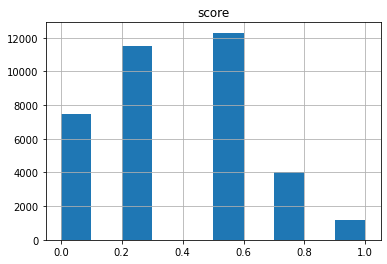

In [5]:
train_dataset.hist()

<AxesSubplot:>

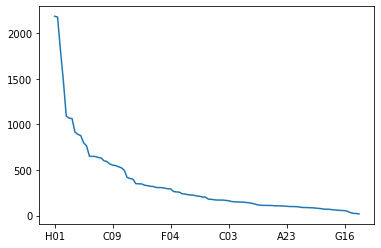

In [6]:
train_dataset['context'].value_counts().plot()


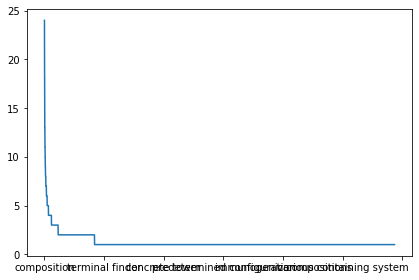

In [7]:
train_dataset['target'].value_counts().plot()
plt.tight_layout()

c:\users\danil\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='score', ylabel='target'>

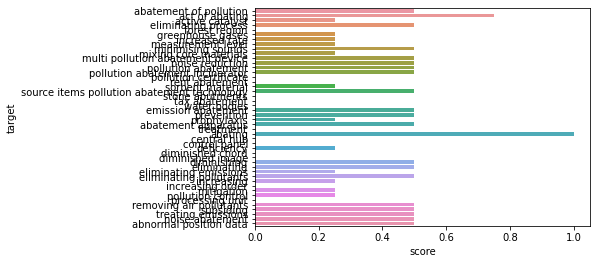

In [8]:
sns.barplot(train_dataset['score'][:50:], train_dataset['target'][:50:])

c:\users\danil\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='score', ylabel='context'>

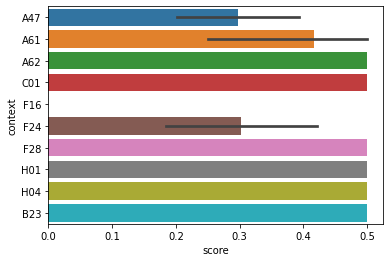

In [9]:
sns.barplot(train_dataset['score'][:50:], train_dataset['context'][:50:])

In [21]:
import tensorflow as tf
import keras.backend as K
from keras.preprocessing.text import text_to_word_sequence, Tokenizer, one_hot
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LSTM, Embedding, Flatten
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import keras

In [11]:
import transformers
from transformers import AutoTokenizer
tokenizer= AutoTokenizer.from_pretrained("bert-base-uncased")

In [12]:
#tokenizing data columns with BERTa-autotokenizer model + TFRobertaModel
## building model with embedding type nn's

In [13]:
import transformers 
from transformers import TFRobertaModel
target=train_dataset['score']

In [14]:
data=tokenizer([(k[0]+';'+k[1], k[2]) for k in zip(train_dataset.anchor, train_dataset.context, train_dataset.target)], padding='max_length', max_length=510)

In [15]:
input_ids=[]
token_type_ids=[]
attention_mask=[]
for i in range(len(train_dataset.anchor)):
    input_ids.append(dict(data)['input_ids'][i])
    token_type_ids.append(dict(data)['token_type_ids'][i])
    attention_mask.append(dict(data)['attention_mask'][i])

In [16]:
input__ids=tf.convert_to_tensor(np.array(input_ids))
token_type__ids=tf.convert_to_tensor(np.array(token_type_ids))
attention__mask=tf.convert_to_tensor(np.array(attention_mask))

In [17]:
from transformers import TFRobertaModel
berta=TFRobertaModel.from_pretrained('bert-base-uncased', trainable=True)

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFRobertaModel: ['nsp___cls', 'bert', 'mlm___cls']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFRobertaModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['roberta']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infere

In [22]:
def create_model(input__ids, attention__mask, berta):
    input_id=tf.keras.Input(shape=(510,), dtype=tf.int32)
    input_mask=tf.keras.Input(shape=(510,), dtype=tf.int32)
    x=berta(input_ids=input_id, attention_mask=input_mask)
    x=keras.layers.AveragePooling1D()(x.last_hidden_state)
    x=keras.layers.Dropout(0.3)(x)
    res=keras.layers.Dense(1)(x)
    model=keras.Model(inputs=[input_id, input_mask], outputs=res)
    model.compile(loss='mae', optimizer='rmsprop', metrics='mae')
    return model

In [23]:
model=create_model(input__ids, attention__mask, berta)

In [24]:
model.fit((input__ids[:10:], attention__mask[:10:]), target[:10:], epochs=3,
         verbose=1, batch_size=500, validation_data=(((input__ids[11:21:], attention__mask[11:21:])), target[11:21:]))

Epoch 1/3
1/1 [==============================] - 288s 288s/step - loss: 1.3367 - mae: 1.3367 - val_loss: 20.8883 - val_mae: 20.8883
Epoch 2/3
1/1 [==============================] - 214s 214s/step - loss: 19.9782 - mae: 19.9782 - val_loss: 7.3941 - val_mae: 7.3941
Epoch 3/3
1/1 [==============================] - 203s 203s/step - loss: 6.1578 - mae: 6.1578 - val_loss: 34.4364 - val_mae: 34.4364
